# Generate Mock Data

In this example we generate mock data with a variety of systematic effects including photometric redshifts, source galaxy distributions, and shape noise.  We then populate a galaxy cluster object. This notebooks is organised as follows:
- Imports and configuration setup
- Generate mock data with different source galaxy options
- Generate mock data with different field-of-view options
- Generate mock data with different galaxy cluster options (only available with the Numcosmo and/or CCL backends). Use the `os.environ['CLMM_MODELING_BACKEND']` line below to select your backend.

In [27]:
import os
## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ct'
#os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [28]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make sure we know which version we're using

In [29]:
clmm.__version__

'0.9.3'

## Import mock data module and setup the configuration 

In [30]:
from clmm.support import mock_data as mock
from clmm import Cosmology

Mock data generation requires a defined cosmology

In [31]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

Mock data generation requires some cluster information. The default is to work with the NFW profile, using the "200,mean" mass definition. The Numcosmo and CCL backends allow for more flexibility (see last section of this notebook)

In [32]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15 # M200,m
cluster_z = 0.3
src_z = 0.8
concentration = 4 
ngals = 1000 # number of source galaxies
cluster_ra = 0.0
cluster_dec = 0.0

## Generate the mock catalog with different source galaxy options

- Clean data: no noise, all galaxies at the same redshift

In [33]:
zsrc_min = cluster_z + 0.1 

In [34]:
ideal_data = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, src_z, ngals=ngals)

- Noisy data: shape noise, all galaxies at the same redshift

In [35]:
noisy_data_src_z = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, src_z,
    shapenoise=0.05, ngals=ngals)

- Noisy data: photo-z errors (and pdfs!), all galaxies at the same redshift

In [36]:
noisy_data_photoz = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, src_z,
    shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

- Clean data: source galaxy redshifts drawn from a redshift distribution instead of fixed `src_z` value. Options are `chang13` for Chang et al. 2013 or `desc_srd` for the distribution given in the DESC Science Requirement Document. No shape noise or photoz errors.

In [37]:
ideal_with_src_dist = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min=zsrc_min,
    zsrc_max=7.0, ngals=ngals)


- Noisy data: galaxies following redshift distribution, redshift error, shape noise

In [38]:
allsystematics = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

In [53]:
allsystematics2 = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'desc_srd', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

Sanity check: checking that no galaxies were originally drawn below zsrc_min, before photoz errors are applied (when relevant)

In [39]:
print('Number of galaxies below zsrc_min:')
print('ideal_data:',np.sum(ideal_data['ztrue']<zsrc_min))
print('noisy_data_src_z:',np.sum(noisy_data_src_z['ztrue']<zsrc_min))
print('noisy_data_photoz:',np.sum(noisy_data_photoz['ztrue']<zsrc_min))
print('ideal_with_src_dist:',np.sum(ideal_with_src_dist['ztrue']<zsrc_min))
print('allsystematics:',np.sum(allsystematics['ztrue']<zsrc_min))

Number of galaxies below zsrc_min:
ideal_data: 0
noisy_data_src_z: 0
noisy_data_photoz: 0
ideal_with_src_dist: 0
allsystematics: 0


### Inspect the catalog data

- Ideal catalog first entries: no noise on the shape measurement, all galaxies at z=0.8, no redshift errors (z = ztrue)

In [40]:
for n in ideal_data.colnames: 
    if n!='id':
        ideal_data[n].format = "%6.3e" 
ideal_data[0:3].pprint(max_width=-1)

    ra        dec         e1         e2         z       ztrue    id
---------- ---------- ---------- ---------- --------- --------- ---
-1.319e-01  4.470e-02 -1.259e-02 -9.633e-03 8.000e-01 8.000e-01   0
 1.340e-01 -4.746e-02 -1.204e-02 -9.751e-03 8.000e-01 8.000e-01   1
-8.716e-02  1.321e-01  5.395e-03 -1.261e-02 8.000e-01 8.000e-01   2


- With photo-z errors

In [41]:
for n in noisy_data_photoz.colnames: 
    if n!='id':
        noisy_data_photoz[n].format = "%6.3e"
noisy_data_photoz[0:3].pprint(max_width=-1)

    ra        dec        e1         e2        z       ztrue         pzbins [61]             pzpdf [61]        id
---------- --------- ---------- --------- --------- --------- ----------------------- ---------------------- ---
 2.440e-01 6.708e-02  2.974e-02 1.017e-01 8.407e-01 8.000e-01 -5.932e-02 .. 1.741e+00 8.550e-22 .. 8.550e-22   0
-1.639e-01 2.273e-01 -7.500e-02 3.604e-02 8.271e-01 8.000e-01 -7.290e-02 .. 1.727e+00 8.550e-22 .. 8.550e-22   1
 6.618e-02 1.009e-01 -2.533e-03 9.444e-02 9.699e-01 8.000e-01  6.990e-02 .. 1.870e+00 8.550e-22 .. 8.550e-22   2


- Histogram of the redshift distribution of background galaxies, for the true (originally drawn) redshift and the redshift once photoz errors have been added. By construction no true redshift occurs below zsrc_min, but some 'observed' redshifts (i.e. including photoz errors) might be.

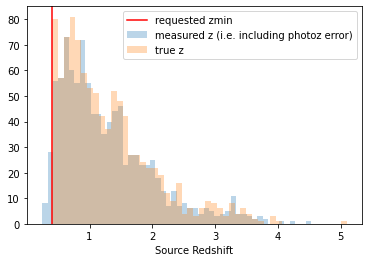

In [42]:
plt.hist(allsystematics['z'], bins=50, alpha=0.3, label='measured z (i.e. including photoz error)');
plt.hist(allsystematics['ztrue'], bins=50, alpha=0.3, label='true z');
plt.axvline(zsrc_min, color='red', label='requested zmin')
plt.xlabel('Source Redshift')
plt.legend()

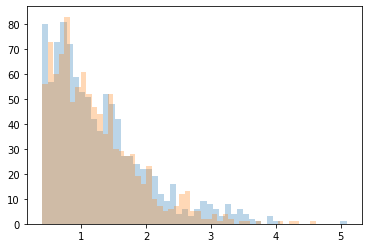

In [68]:
plt.hist(allsystematics['ztrue'], bins=50, alpha=0.3, label='true z');
plt.hist(allsystematics2['ztrue'], bins=50, alpha=0.3, label='true z');


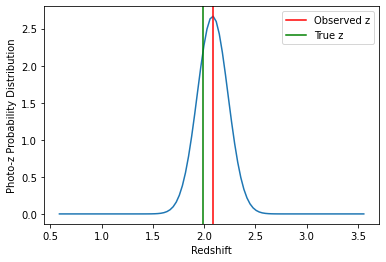

In [43]:
# pdz for one of the galaxy in the catalog, 
galid = 0
plt.plot(allsystematics['pzbins'][galid], allsystematics['pzpdf'][galid])
plt.axvline(allsystematics['z'][galid], label='Observed z', color='red')
plt.axvline(allsystematics['ztrue'][galid], label='True z', color='g')
plt.xlabel('Redshift')
plt.ylabel('Photo-z Probability Distribution')
plt.legend(loc=1)

Populate in a galaxy cluster object

In [44]:
# At the moment mock data only allow for a cluster centred on (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, allsystematics)

Plot source galaxy ellipticities

Text(0, 0.5, 'Ellipticity 2')

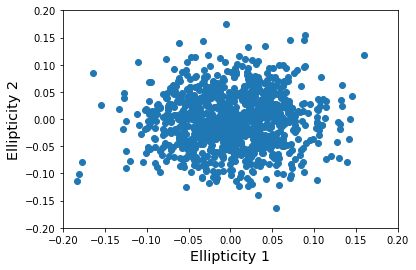

In [45]:
plt.scatter(gc_object.galcat['e1'],gc_object.galcat['e2'])

plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Ellipticity 1',fontsize='x-large')
plt.ylabel('Ellipticity 2',fontsize='x-large')

## Generate the mock data catalog with different field-of-view options

In the examples above, `ngals=1000` galaxies were simulated in a field corresponding to a 8 Mpc/h x 8 Mpc/h (proper distance) square box at the cluster redshift (this is the default). The user may however vary the field size and/or provide a galaxy density (instead of a number of galaxies). This is examplified below, using the `allsystematics` example.

- `ngals = 1000` in a 4 x 4 Mpc/h box. Asking for the same number of galaxies in a smaller field of view yields high galaxy density

In [46]:
allsystematics2 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'chang13', zsrc_min=zsrc_min, zsrc_max=7.0, 
                                               shapenoise=0.05, photoz_sigma_unscaled=0.05,
                                               field_size=4, ngals=ngals)

/pbs/home/c/ccombet/.conda/envs/mydesc3/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


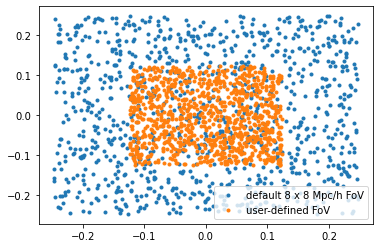

In [47]:
plt.scatter(allsystematics['ra'],allsystematics['dec'], marker='.', label = 'default 8 x 8 Mpc/h FoV')
plt.scatter(allsystematics2['ra'],allsystematics2['dec'],marker='.', label = 'user-defined FoV')
plt.legend()

- Alternatively, the user may provide a galaxy density (here 1 gal/arcmin2 to roughly match 1000 galaxies, given the configuration) and the number of galaxies to draw will automatically be adjusted to the box size.

In [66]:
allsystematics3 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'chang13', zsrc_min=zsrc_min, zsrc_max=100.0, 
                                              shapenoise=0.05, photoz_sigma_unscaled=0.05, 
                                              ngal_density=25)
print(f'Number of drawn galaxies = {len(allsystematics3)}')

Number of drawn galaxies = 19037


In [65]:
allsystematics4 = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 
                                               'desc_srd', zsrc_min=zsrc_min, zsrc_max=100.0, 
                                              shapenoise=0.05, photoz_sigma_unscaled=0.05, 
                                              ngal_density=25)
print(f'Number of drawn galaxies = {len(allsystematics4)}')

Number of drawn galaxies = 68486


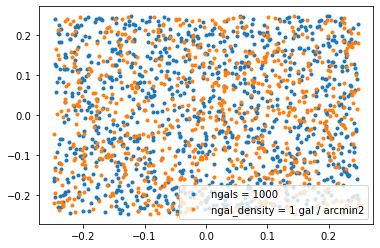

In [49]:
plt.scatter(allsystematics['ra'],allsystematics['dec'], marker='.', label = 'ngals = 1000')
plt.scatter(allsystematics3['ra'],allsystematics3['dec'],marker='.', label = 'ngal_density = 1 gal / arcmin2')
plt.legend()

## Generate mock data with different galaxy cluster options
WARNING: Available options depend on the modeling backend:
- Cluster-toolkit allows for other values of the overdensity parameter, but is retricted to working with the mean mass definition
- Both CCL and Numcosmo allow for different values of the overdensity parameter, but work with both the mean and critical mass definition
- Numcosmo further allows for the Einasto or Burkert density profiles to be used instead of the NFW profile



### Changing the overdensity parameter (all backend) - `delta_so` keyword (default = 200)

In [50]:
allsystematics_500mean = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, 'chang13', delta_so=500,
    zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

### Using the critical mass definition (Numcosmo and CCL only) - `massdef` keyword (default = 'mean')
WARNING: error will be raised if using the cluster-toolkit backend

In [51]:
allsystematics_200critical = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo,'chang13',  massdef='critical', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

### Changing the halo density profile (Numcosmo only) - `halo_profile_model` keyword (default = 'nfw')
WARNING: error will be raised if using the cluster-toolkit or CCL backends

In [52]:
allsystematics_200m_einasto = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo,'chang13', halo_profile_model='einasto', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.05, photoz_sigma_unscaled=0.05, ngals=ngals)

ValueError: Halo density profile model einasto not currently supported